In [5]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import mplfinance as mpf

In [6]:
class IndicatorBase:
    def __init__(self, df: pd.DataFrame):
        """
        Initializes with a market DataFrame (must include 'Close', 'High', 'Low', 'Volume').
        """
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Expected a pandas DataFrame.")
        required_cols = {"Open", "High", "Low", "Close", "Volume"}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DataFrame must contain columns: {required_cols}")
        
        self.df = df.copy()

    def compute_indicators(self):
        """Computes common technical indicators and appends them to the DataFrame."""
        self.df["50EMA"] = ta.ema(self.df["Close"], length=50)
        self.df["200EMA"] = ta.ema(self.df["Close"], length=200)
        self.df["RSI"] = ta.rsi(self.df["Close"], length=14)
        self.df["ATR"] = ta.atr(self.df["High"], self.df["Low"], self.df["Close"], length=14)
        self.df["ATR_50"] = self.df["ATR"].rolling(50).mean()

        macd = ta.macd(self.df["Close"], fast=12, slow=26, signal=9)
        self.df["MACD"] = macd["MACD_12_26_9"]
        self.df["Signal"] = macd["MACDs_12_26_9"]
        self.df["MACD_Hist"] = self.df["MACD"] - self.df["Signal"]

        bb = ta.bbands(self.df["Close"], length=20)
        self.df["BB_Upper"] = bb["BBU_20_2.0"]
        self.df["BB_Lower"] = bb["BBL_20_2.0"]
        self.df["BB_Width"] = (self.df["High"].rolling(20).max() - self.df["Low"].rolling(20).min()) / self.df["Close"].rolling(20).mean()

        self.df["OBV"] = (np.sign(self.df["Close"].diff()) * self.df["Volume"]).cumsum()
        self.df["Support"] = self.df["Low"].rolling(20).min()
        self.df["Resistance"] = self.df["High"].rolling(20).max()

        self.df.dropna(inplace=True)
        return self.df


# --- Example usage ---
if __name__ == "__main__":
    # Step 1: Load data
    df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

    # Step 2: Compute indicators
    indicators = IndicatorBase(df)
    df_indicators = indicators.compute_indicators()

    # Step 3: View result
    # print(df_indicators.tail())

    # (Optional) Save to CSV
    # df_indicators.to_csv("aapl_with_indicators.csv")


In [7]:
def plot_candlestick_with_indicators(df, title="Candlestick with Indicators", window=100, save_path=None):
    df_plot = df.tail(window).copy()
    ohlc = df_plot[["Open", "High", "Low", "Close", "Volume"]].copy()
    apds = []

    panel_counter = 0  # panel 0 = price
    panel_ratios = [2]  # price panel

    # Volume is automatically assigned panel 1 when volume=True
    panel_counter += 1
    panel_ratios.append(0.5)  # smaller height for volume

    # Track additional panel numbers
    rsi_panel = None
    macd_panel = None

    # Add moving averages
    if "50EMA" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["50EMA"], panel=0, color="blue", width=1.0))
    if "200EMA" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["200EMA"], panel=0, color="purple", width=1.0))

    # Bollinger Bands
    if "BB_Upper" in df_plot.columns and "BB_Lower" in df_plot.columns:
        apds.append(mpf.make_addplot(df_plot["BB_Upper"], panel=0, color="grey", linestyle="--"))
        apds.append(mpf.make_addplot(df_plot["BB_Lower"], panel=0, color="grey", linestyle="--"))

    # RSI (optional panel)
    if "RSI" in df_plot.columns:
        panel_counter += 1
        rsi_panel = panel_counter
        apds.append(mpf.make_addplot(df_plot["RSI"], panel=rsi_panel, color='orange', ylabel='RSI'))
        panel_ratios.append(1)

    # MACD (optional panel)
    if "MACD" in df_plot.columns and "Signal" in df_plot.columns:
        panel_counter += 1
        macd_panel = panel_counter
        apds.append(mpf.make_addplot(df_plot["MACD"], panel=macd_panel, color='green', ylabel='MACD'))
        apds.append(mpf.make_addplot(df_plot["Signal"], panel=macd_panel, color='red'))
        if "MACD_Hist" in df_plot.columns:
            apds.append(mpf.make_addplot(df_plot["MACD_Hist"], panel=macd_panel, type='bar', color='gray', alpha=0.5))
        panel_ratios.append(1)

    # Plot config
    plot_kwargs = dict(
        type='candle',
        style='charles',
        title=title,
        ylabel='Price',
        ylabel_lower='Volume',
        volume=True,
        addplot=apds,
        figscale=1.2,
        figratio=(14, 9),
        panel_ratios=panel_ratios
    )

    if save_path:
        plot_kwargs["savefig"] = save_path

    mpf.plot(ohlc, **plot_kwargs)

    if save_path:
        print(f"Plot saved to {save_path}")


In [8]:
plot_candlestick_with_indicators(df_indicators, save_path="candlestick_price_action_withi_indicators.png")

Plot saved to candlestick_price_action_withi_indicators.png


In [10]:

class PriceActionBase:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def compute_candlestick_patterns(self):
        """Detects basic candlestick patterns and adds flags."""
        df = self.df

        # Bullish Engulfing
        df['bullish_engulfing'] = ((df['Close'].shift(1) < df['Open'].shift(1)) &
                                   (df['Close'] > df['Open']) &
                                   (df['Close'] > df['Open'].shift(1)) &
                                   (df['Open'] < df['Close'].shift(1)))

        # Bearish Engulfing
        df['bearish_engulfing'] = ((df['Close'].shift(1) > df['Open'].shift(1)) &
                                   (df['Close'] < df['Open']) &
                                   (df['Close'] < df['Open'].shift(1)) &
                                   (df['Open'] > df['Close'].shift(1)))

        # Hammer
        df['hammer'] = ((df['High'] - df['Low']) > 3 * (df['Open'] - df['Close'])) & \
                       ((df['Close'] - df['Low']) / (.001 + df['High'] - df['Low']) > 0.6) & \
                       ((df['Open'] - df['Low']) / (.001 + df['High'] - df['Low']) > 0.6)

        # Doji
        df['doji'] = (abs(df['Close'] - df['Open']) <= (0.1 * (df['High'] - df['Low'])))

        # Inside Bar
        df['inside_bar'] = ((df['High'] < df['High'].shift(1)) &
                            (df['Low'] > df['Low'].shift(1)))

        self.df = df
        return self.df

    def compute_support_resistance(self, window=20):
        """Finds local support and resistance levels using rolling min/max."""
        self.df['local_support'] = self.df['Low'].rolling(window, center=True).min()
        self.df['local_resistance'] = self.df['High'].rolling(window, center=True).max()
        return self.df


In [13]:
if __name__ == "__main__":
    df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")
    df = df.tail(1000)

    price_action = PriceActionBase(df)
    df_price_action = price_action.compute_candlestick_patterns()
    df_price_action = price_action.compute_support_resistance()

    print(df_price_action[['Close', 'bullish_engulfing', 'hammer', 'local_support', 'local_resistance']].tail(10))

                                  Close  bullish_engulfing  hammer  \
Date                                                                 
2025-02-21 00:00:00+05:30  22795.900391              False   False   
2025-02-24 00:00:00+05:30  22553.349609              False   False   
2025-02-25 00:00:00+05:30  22547.550781              False   False   
2025-02-27 00:00:00+05:30  22545.050781              False   False   
2025-02-28 00:00:00+05:30  22124.699219              False   False   
2025-03-03 00:00:00+05:30  22119.300781              False   False   
2025-03-04 00:00:00+05:30  22082.650391              False   False   
2025-03-05 00:00:00+05:30  22337.300781              False   False   
2025-03-06 00:00:00+05:30  22544.699219              False    True   
2025-03-07 00:00:00+05:30  22552.500000              False   False   

                           local_support  local_resistance  
Date                                                        
2025-02-21 00:00:00+05:30   21964.599

In [22]:
df_price_action.to_csv('Price_action.csv')

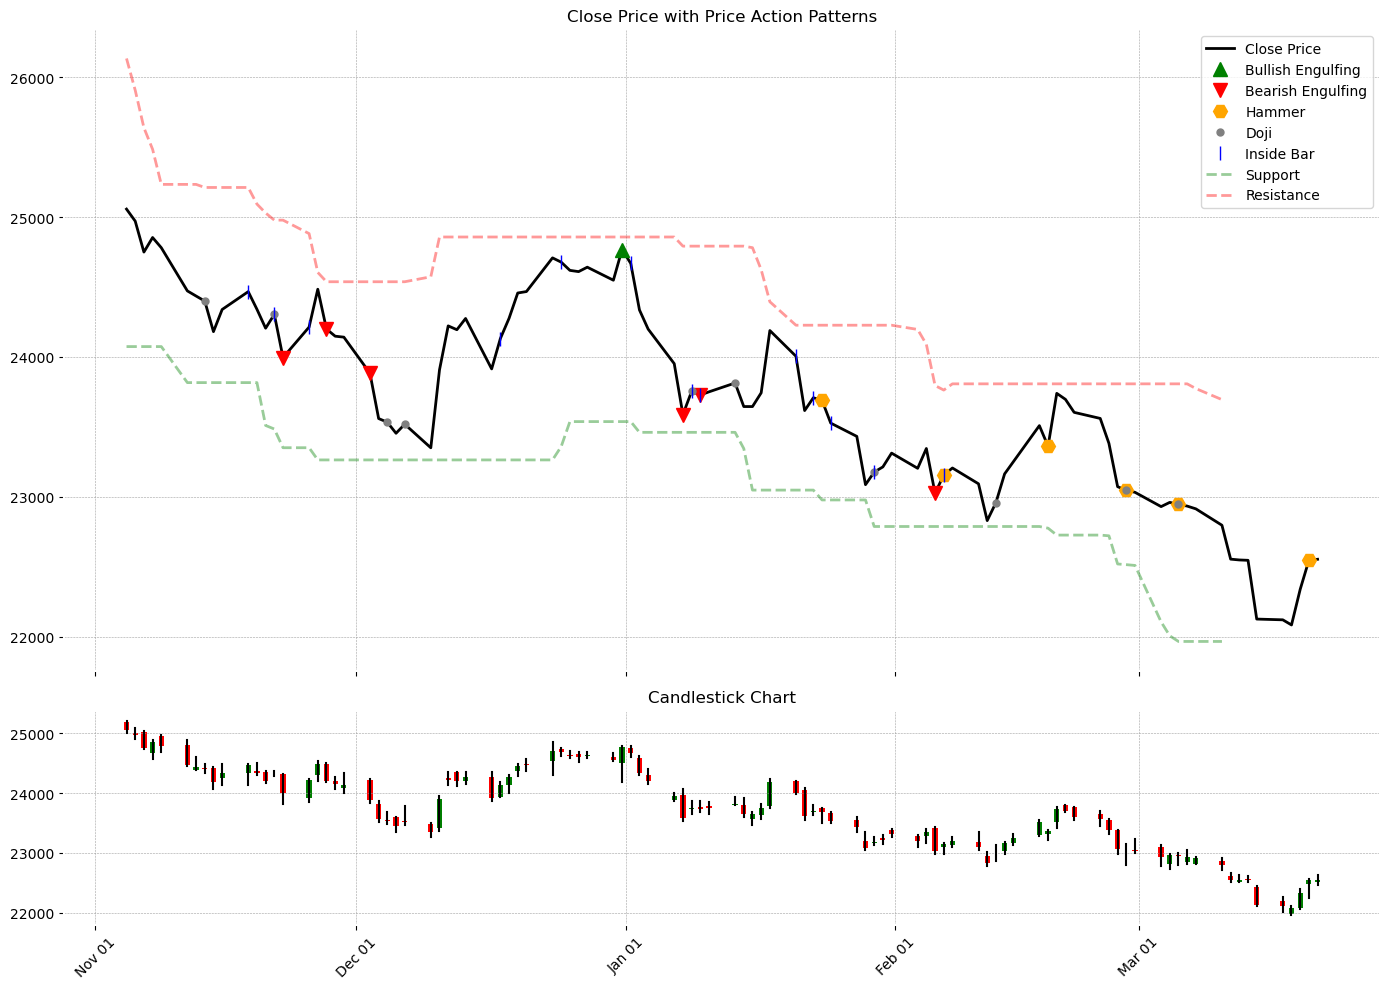

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# Load data
df = pd.read_csv("price_action.csv")
df.index = pd.date_range(end=pd.Timestamp.today(), periods=len(df), freq='B')
df = df.tail(100).copy()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
df = df.replace([np.inf, -np.inf], np.nan)

# Convert pattern flags to boolean
pattern_cols = ['bullish_engulfing', 'bearish_engulfing', 'hammer', 'doji', 'inside_bar']
for col in pattern_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# Setup the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- TOP: Line chart with pattern markers ---
ax1.plot(df.index, df["Close"], label="Close Price", color='black')

# Pattern markers
marker_kwargs = dict(markersize=10, linestyle='None')
if df['bullish_engulfing'].any():
    ax1.plot(df.index[df['bullish_engulfing']], df['Close'][df['bullish_engulfing']],
             marker='^', color='green', label='Bullish Engulfing', **marker_kwargs)
if df['bearish_engulfing'].any():
    ax1.plot(df.index[df['bearish_engulfing']], df['Close'][df['bearish_engulfing']],
             marker='v', color='red', label='Bearish Engulfing', **marker_kwargs)
if df['hammer'].any():
    ax1.plot(df.index[df['hammer']], df['Close'][df['hammer']],
             marker='H', color='orange', label='Hammer', **marker_kwargs)
if df['doji'].any():
    ax1.plot(df.index[df['doji']], df['Close'][df['doji']],
             marker='.', color='gray', label='Doji', **marker_kwargs)
if df['inside_bar'].any():
    ax1.plot(df.index[df['inside_bar']], df['Close'][df['inside_bar']],
             marker='|', color='blue', label='Inside Bar', **marker_kwargs)

# Support & resistance
if 'local_support' in df.columns:
    ax1.plot(df.index, df['local_support'], '--', color='green', alpha=0.4, label='Support')
if 'local_resistance' in df.columns:
    ax1.plot(df.index, df['local_resistance'], '--', color='red', alpha=0.4, label='Resistance')

ax1.set_title("Close Price with Price Action Patterns")
ax1.legend()
ax1.grid(True)

# --- BOTTOM: Candlestick chart ---
candle_width = 0.6
wick_width = 1.5

for idx, row in df.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    # Wick
    ax2.plot([idx, idx], [row['Low'], row['High']], color='black', linewidth=wick_width)
    # Body
    ax2.add_patch(Rectangle(
        (mdates.date2num(idx) - candle_width / 2, min(row['Open'], row['Close'])),
        candle_width,
        abs(row['Close'] - row['Open']),
        color=color,
        linewidth=0
    ))

ax2.set_title("Candlestick Chart")
ax2.grid(True)

# --- X-axis formatting ---
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("combined_line_and_candle.png", dpi=150)
plt.show()
